Nama : Abriel Salsabina P.Y <br>
NIM : 211351001 <br>
Kelas : IF Pagi B<br>

#Import Datasets

Seperti biasa langkah awal adalah memgimport file token kaggle untuk mendapatkan akses datasets dari kaggle.com.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrielsalsabina","key":"664d69a1b97da1f2cc0eb71ff2949645"}'}

Dilanjut dengan membuat folder bagi file tersebut

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


Mengunduh datasets yang kita inginkan dengan perintah dibawah

In [3]:
!kaggle datasets download -d fedesoriano/heart-failure-prediction

  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 14.2MB/s]


Extract datasetsnya lalu masukkan ke dalam sebuah folder.

In [4]:
!unzip heart-failure-prediction.zip -d data
!ls data

Archive:  heart-failure-prediction.zip
  inflating: data/heart.csv          
heart.csv


#Import Library

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
import pickle

#Data Discovery

Langkah pertama pada tahap ini adalah membaca datasets yang tadi telah diextract.

In [6]:
df2 = pd.read_csv('data/heart.csv')
df2.head(20)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Disini kita melihat apakah terdapat nilai null/NaN pada datasetsnya.

In [7]:
df2.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Tidak terdapat nilai null yaa.

In [8]:
df2.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

Diatas merupakan jumlah nilai unique pada kolom-kolom datasets, bisa dilihat terdapat beberapa kolom yang hanya memiliki 2 nilai unik, itu biasanya mengindikasikan true/false atau benar/salah. Mari kita cek apakah datasetnya memiliki nilai duplicate.

In [23]:
df2.RestingECG.unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [9]:
df2.duplicated().sum()

0

Aman ya, 0 duplicate data.

In [10]:
df2.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Kita bisa lihat bahwa datasetnya memiliki 918 baris data sebelum diproses, namun nilai min bagi restingbp dan cholesterol terlalu rendah. Tidak mungkin bukan restingbp(heartbeat) bisa mencapai 0?? itu artinya pasien tersebut meninggal :") dan cholesterol 0 itu juga sangat mustahil karena setidaknya manusia membutuhkan kolesterol baik untuk hidup. Mari lanjut pada bagian EDA, kita akan memperbaiki nilai diatas pada tahap pre processing.

#EDA

Okeh, pertama-pertama kita akan melihat jumlah orang yang memiliki penyakit jantung dan yang tidak memiliki penyakit jantung.

<Axes: xlabel='HeartDisease', ylabel='count'>

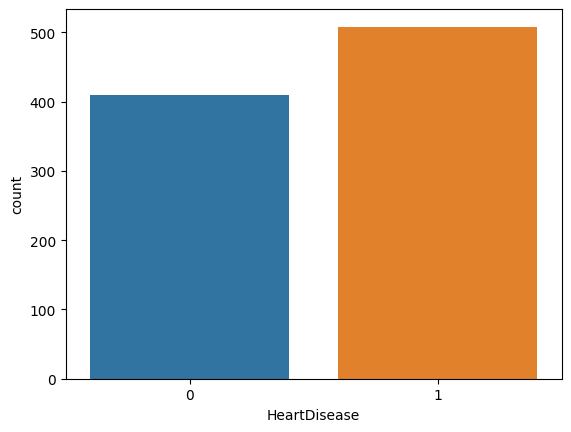

In [11]:
sns.countplot(data=df2, x='HeartDisease')

hmm...terlihat cukup balance ya, tidak terlalu condong ke satu sisi, seharusnya aman dan tidak perlu kita lakukan tahap sampling (menambah/mengurangi data).

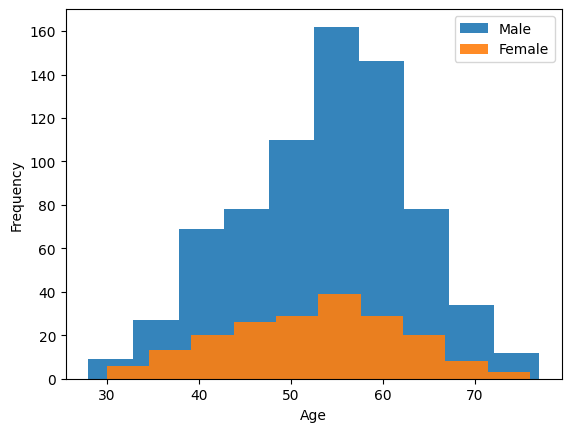

In [12]:
plt.hist(df2[df2['Sex'] == 'M']['Age'], bins=10, alpha=0.9, label='Male')
plt.hist(df2[df2['Sex'] == 'F']['Age'], bins=10, alpha=0.9, label='Female')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Dari plot diatas bisa kita lihat bahwa laki-laki lebih cenderung terkena penyakit jantung terutama pada saat berada diusia dewasa-lansia. Sedangkan wanita memiliki nilai yang lebih rendah.

Kita akan membuat variable untuk menampung jumlah org yang mengidap kesakitan dada berdasarkan kategorinya.

In [13]:
chest_count = df2.ChestPainType.value_counts()

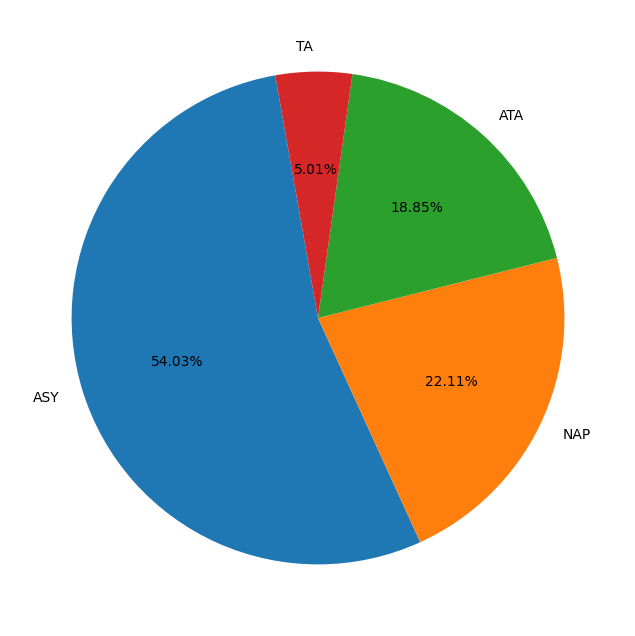

In [14]:
plt.figure(figsize=(16, 8))
plt.pie(chest_count, labels=chest_count.index, autopct='%1.2f%%', startangle=100)
plt.show()

Bisa dilihat bahwa mayoritas orang mengidap rasa sakit dada bertype ASY atau asymptomatic chestpain.

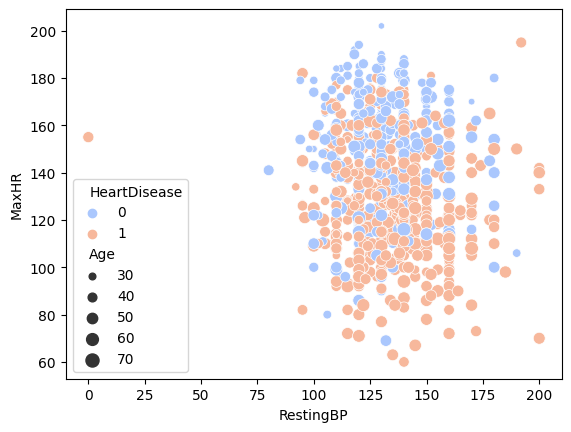

In [15]:
sns.scatterplot(
    x="RestingBP",
    y="MaxHR",
    hue="HeartDisease",
    size="Age",
    data=df2,
    sizes=(20, 100),
    palette="coolwarm",
)
plt.show()

Diatas menunjukkan korelasi antara RestingBP, MaxHR dan Age dimana umur yang rendah memiliki bulatan yang lebih kecil. hmm, ada satu data nyasar ya di nilai 0, jikalau kita bisa melakukan preprocessing terlebih dahulu mungkin kita bisa menunjukkan grafik yang lebih detail.

<Axes: xlabel='MaxHR', ylabel='Sex'>

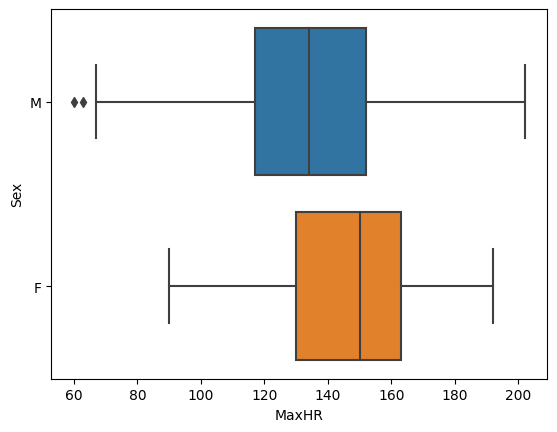

In [16]:
sns.boxplot(data=df2,x=df2.MaxHR,y=df2.Sex)

Disini menunjukkan heart rate wanita jauh lebih tinggi dibandingkan pria. Mungkinkah heartrate ini juga memiliki pengaruh yang besar dalam menentukan seseorang memiliki penyakit jantung atau tidak(?). Kita akan lanjut dengan tahap preprocessing.

#Preprocessing

Kita akan masukkan Label Encoder untuk mengubah data kategorial menjadi numerical.

In [17]:
le = LabelEncoder()

Karena tadi terdapat nilai 0 pada Cholesterol dan RestingBP, mari kita hilangkan data tersebut. Dengan mengetahui nilai mean dari masing-masing mean, kita bisa memfilter nilai yang abnormal dalam datasets.

In [18]:
Q1 = df2[["Cholesterol", "RestingBP"]].quantile(0.25)
Q3 = df2[["Cholesterol", "RestingBP"]].quantile(0.75)
IQR = Q3 - Q1

mean_cholesterol = df2["Cholesterol"].mean()
mean_RestingBP = df2["RestingBP"].mean()

# Replace outliers with mean values in each column
df_cop = df2.copy()  # Create a copy to avoid modifying the original data
df_filtered = df_cop[~((df_cop["Cholesterol"] < (Q1["Cholesterol"] - 1.5 * IQR["Cholesterol"])) |
                     (df_cop["Cholesterol"] > (Q3["Cholesterol"] + 1.5 * IQR["Cholesterol"])) |
                     (df_cop["RestingBP"] < (Q1["RestingBP"] - 1.5 * IQR["RestingBP"])) |
                     (df_cop["RestingBP"] > (Q3["RestingBP"] + 1.5 * IQR["RestingBP"])))]

Kita memasukkan hasil dataframenya pada df_filtered

In [19]:
df_filtered["Sex"]=le.fit_transform(df_filtered["Sex"])
df_filtered["ChestPainType"]=le.fit_transform(df_filtered["ChestPainType"])
df_filtered["RestingECG"]=le.fit_transform(df_filtered["RestingECG"])
df_filtered["ExerciseAngina"]=le.fit_transform(df_filtered["ExerciseAngina"])
df_filtered["ST_Slope"]=le.fit_transform(df_filtered["ST_Slope"])
df_filtered.head()

<ipython-input-19-ae920ae316db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Sex"]=le.fit_transform(df_filtered["Sex"])
<ipython-input-19-ae920ae316db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["ChestPainType"]=le.fit_transform(df_filtered["ChestPainType"])
<ipython-input-19-ae920ae316db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


Diatas merupakan hasil dari Label Encoder, dimana nilai unik kategorial diubah menjadi nomerical biasanya dimulai dari angka 0 hingga n.

In [22]:
df_filtered.RestingECG.unique()

array([1, 2, 0])

In [20]:
df_filtered.to_csv('data.csv', index=False)

In [21]:
x=df_filtered.drop(columns='HeartDisease')
y=df_filtered.HeartDisease
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

Membuat data train dengan 30% data test dan 70% data train.

#Modeling

Kita lanjut dengan process modeling, disini saya menggunakan n 23 :") setelah mencoba berkali-kali untuk mencari persentase yang bagus, ketemulah angka 23 ini.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

Accuracy: 0.7116279069767442
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       106
           1       0.74      0.67      0.70       109

    accuracy                           0.71       215
   macro avg       0.71      0.71      0.71       215
weighted avg       0.71      0.71      0.71       215



Hasil percentasenya adalah 71%

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[80 26]
 [36 73]]


Dan confusion matrixnya pun masih masuk akal, namun tidak terlalu akurat.

In [ ]:
test = [[40, 1, 1, 140, 289, 0, 1, 172, 0, 0.0, 2]]
test2 = [[49, 0, 2, 160, 180, 0, 1, 98, 0, 1.5, 1]]
pred = knn.predict(test2)
print(knn.predict(test2))
if pred == [0]:
  print('tidak memiliki penyakit jantung')
elif pred == [1]:
  print('memiliki penyakit jantung')

[1]
memiliki penyakit jantung


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Data test diatas cukup akurat!

#Visualisasi Hasil Algorithm

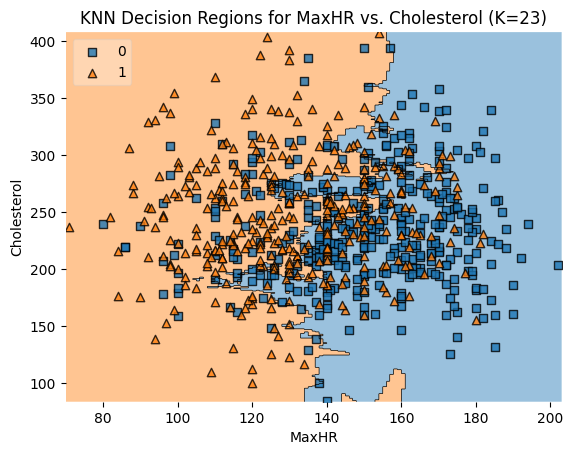

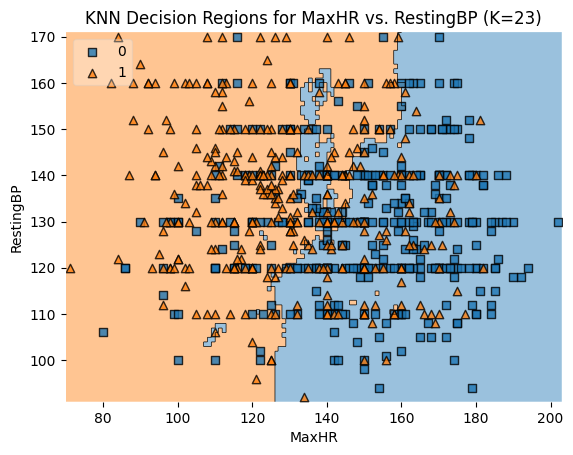

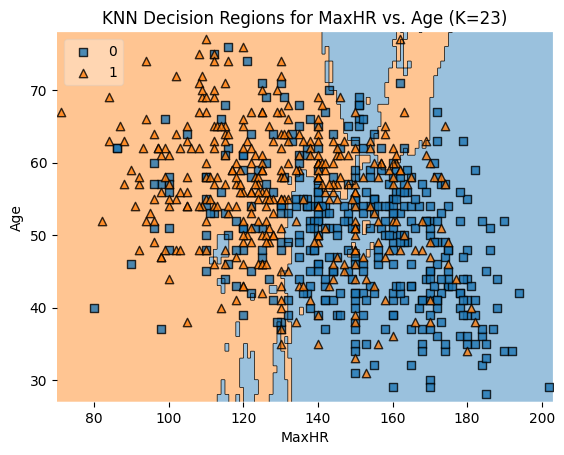

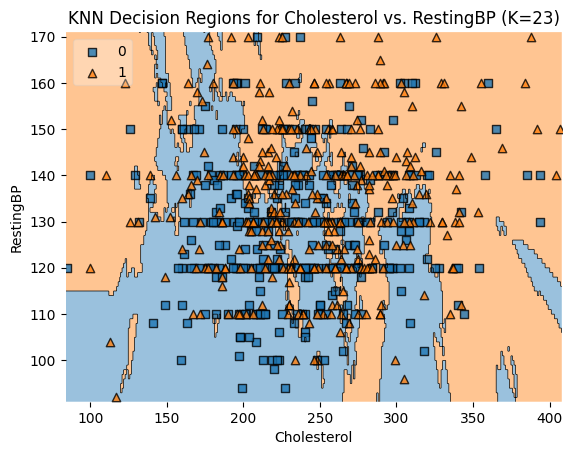

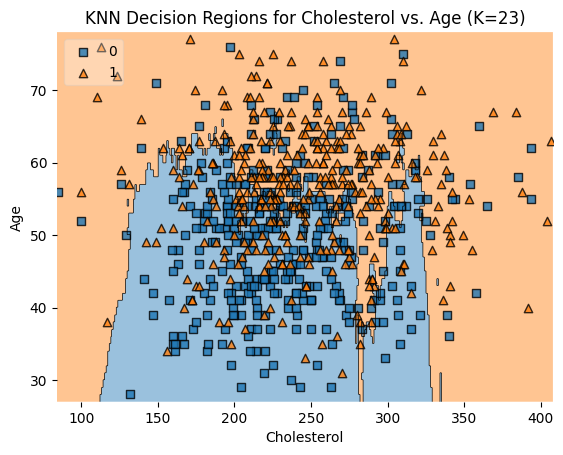

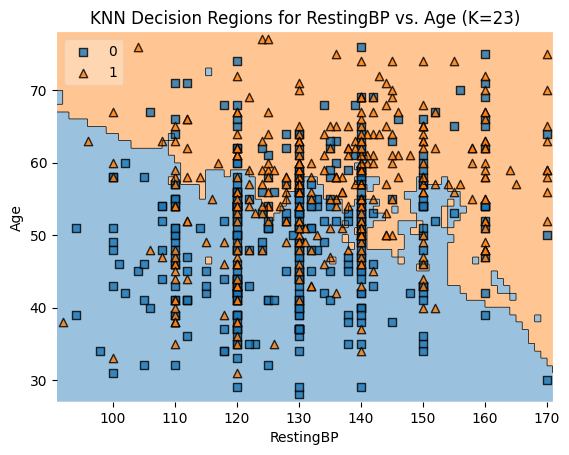

In [ ]:
k = 23  # Set the desired number of neighbors

# Iterate through unique pairs of features
feature_pairs = [
    ("MaxHR", "Cholesterol"),
    ("MaxHR", "RestingBP"),
    ("MaxHR", "Age"),
    ("Cholesterol", "RestingBP"),
    ("Cholesterol", "Age"),
    ("RestingBP", "Age"),
]



for x_column, y_column in feature_pairs:
    X = df_filtered[[x_column, y_column]].values
    y = df_filtered['HeartDisease'].astype(int).values

    # Train the KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    # Create the decision region plot
    plot_decision_regions(X, y, clf=knn, legend=2)

    # Add axis labels and title
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f'KNN Decision Regions for {x_column} vs. {y_column} (K={k})')

    plt.show()



Diatas merupakan visualisasii dari KNN bagi beberapa fitur yang menurut saya memiliki korelasi erat.

#Export dengan pickle

In [ ]:
with open("model.pkl", "wb") as f:
    pickle.dump(knn, f)